## BATCH aligner

#### Introduction

In metabolomics and natural product research, it is crucial to ensure that features detected across multiple batches of mass spectrometry (MS) data are accurately aligned and comparable. This notebook provides a comprehensive workflow for aligning MS features across different batches, focusing on interbatch comparison and annotation of compounds. The method is designed specifically for features that include MS/MS data, which allows for a more precise and reliable alignment process.

#### Objectives

##### The primary goals of this notebook are:

* Feature Alignment: Align MS features from multiple batches based on retention time (RT) and mass-to-charge ratio (m/z) thresholds.
* Cosine Similarity Calculation: Filter aligned features by computing the cosine similarity between their MS/MS spectra to ensure they are indeed similar.
* Visualization: Plot and visualize the aligned features to facilitate further analysis and validation.

#### Methodology

##### The notebook is structured to perform the following key steps:

1. Data Import and Setup: Read MS feature data from .csv files corresponding to different batches and set up the necessary environment for processing.

Data Requirements:

    1. Process each batch using MZMine accordingly.
    2. Export the aligned feature list for applying the exported data to:
        (a) GNPS-FBMN (xxxx_quant.csv + xxxx.mgf)
        (b) MetaboAnalyst (xxxx_MetaboAnalyst.csv)
    3. Name the exported files as follows: xxxx_batch#.mgf, xxxx_batch#.csv, xxxx_batch#_MetaboAnalyst.csv
        xxxx is the "project name" (e.g., "PHerb1"), and # refers to the batch number.


2. Feature Alignment: Use the align_features function to merge features from different batches based on predefined RT and m/z thresholds.
3. Cosine Similarity Filtering: Apply the calculate_cosine_similarity function to compare MS/MS spectra of aligned features, retaining only those with high similarity.
4. Visualization: Utilize plotting functions to visualize the spectra of aligned features, both for specific scan numbers and for randomly selected features.

#### Notes

* Scope: This method focuses exclusively on features with MS/MS data, as those without MS/MS data are outside the scope of this alignment approach.
* Application: The alignment and visualization techniques provided here are tailored for applications in natural products and metabolomics research, where accurate interbatch comparison is essential.

---
#### Import the necessary libraries for data manipulation, computation, and visualization.


In [1]:
import pandas as pd  # pandas: for handling data in DataFrames
import numpy as np  # numpy: for numerical operations
import matplotlib.pyplot as plt  # matplotlib: for plotting data
from sklearn.metrics.pairwise import cosine_similarity  # sklearn: for cosine similarity computation
from tqdm import tqdm  # tqdm: for progress bars
import random  # random: for random operations
import os  # os: for operating system interfaces
from pyteomics import mgf  # pyteomics: for handling MGF files
import plotly.graph_objects as go  # plotly: for interactive plots
from itertools import cycle  # itertools: for creating iterators

---

In [2]:
# Directory containing .mgf files and related MetaboAnalyst.csv files
directory_path = r'C:\Users\borge\Documents\Batch_correction_from_MZmine\CQ_Batches'

# Define the project
project_prefix = "Controles_Lote_"

---
#### Parse the .mgf Files

This sets up the directory path for the MGF and MetaboAnalyst.csv files and defines a function to parse the MGF files. Follow these steps:

The parse_mgf_files function manually reads each MGF file, extracts the spectra data, and stores it in a dictionary. The purpose is to load and verify the spectral data from the MGF files for further analysis.

In [3]:
# Function to parse MGF files manually
def parse_mgf_files(directory_path):
    mgf_files = [os.path.join(directory_path, file) for file in os.listdir(directory_path) if file.endswith('.mgf')]
    spectra = {}
    for mgf_file in mgf_files:
        print(f"Processing MGF file: {mgf_file}")
        batch_name = os.path.basename(mgf_file).replace('.mgf', '')
        spectra[batch_name] = []
        with open(mgf_file, 'r') as file:
            current_spectrum = None
            for line in file:
                line = line.strip()
                if line == "BEGIN IONS":
                    current_spectrum = {'params': {}, 'm/z array': [], 'intensity array': []}
                elif line == "END IONS":
                    if current_spectrum:
                        spectra[batch_name].append(current_spectrum)
                elif '=' in line:
                    key, value = line.split('=', 1)
                    current_spectrum['params'][key] = value
                else:
                    parts = line.split()
                    if len(parts) == 2:
                        mz, intensity = map(float, parts)
                        current_spectrum['m/z array'].append(mz)
                        current_spectrum['intensity array'].append(intensity)
    return spectra

# Parse .mgf files to get spectra
spectra = parse_mgf_files(directory_path)

# Verify that the spectra have been loaded correctly
for batch_name, batch_spectra in spectra.items():
    print(f"Batch: {batch_name}, Number of spectra: {len(batch_spectra)}")

Processing MGF file: C:\Users\borge\Documents\Batch_correction_from_MZmine\CQ_Batches\Controles_Lote_1_2024_10_02.mgf
Processing MGF file: C:\Users\borge\Documents\Batch_correction_from_MZmine\CQ_Batches\Controles_Lote_2_2024_10_02.mgf
Processing MGF file: C:\Users\borge\Documents\Batch_correction_from_MZmine\CQ_Batches\Controles_Lote_3_2024_10_08.mgf
Processing MGF file: C:\Users\borge\Documents\Batch_correction_from_MZmine\CQ_Batches\Controles_Lote_4_2024_10_08.mgf
Batch: Controles_Lote_1_2024_10_02, Number of spectra: 49
Batch: Controles_Lote_2_2024_10_02, Number of spectra: 51
Batch: Controles_Lote_3_2024_10_08, Number of spectra: 29
Batch: Controles_Lote_4_2024_10_08, Number of spectra: 23


---
#### Extract Values and Create DataFrames from .csv Files

This step reads the MetaboAnalyst.csv files, extracts the relevant data, and creates a DataFrame for each file.

    1. Process each file to extract scan numbers, mz values, and rt values.
    2. Handle missing data by replacing NaN values with 0.
    3. Convert data types appropriately for analysis.
    4. Add batch information to each DataFrame.

* The function extract_values_and_create_dfs reads _MetaboAnalyst.csv files from the specified directory, extracting key information such as scan_number, mz_value, rt_value, and the batch identifier.
* The first row of each batch, which contains classification information, is excluded from the alignment process but saved for future use.

The processed DataFrames are stored in a dictionary for further analysis.

In [4]:
# Find all _MetaboAnalyst.csv files in the directory
file_paths = [os.path.join(directory_path, file) for file in os.listdir(directory_path) if file.endswith('_MetaboAnalyst.csv')]

# Function to read _MetaboAnalyst.csv files and create DataFrames
def extract_values_and_create_dfs(file_paths):
    dfs = {}
    first_rows = {}

    for file_path in file_paths:
        df = pd.read_csv(file_path)
        
        # Extract filename for batch identification
        filename = os.path.basename(file_path).replace('_MetaboAnalyst.csv', '')
        
        # Extract values from the first column
        df[['scan_number', 'mz_value', 'rt_value']] = df.iloc[:, 0].str.extract(r'(\d+)/([\d.]+)mz/([\d.]+)min')
        
        # Replace NaN values with 0
        df = df.fillna(0)
        
        # Convert extracted values to appropriate data types
        df['scan_number'] = df['scan_number'].astype(int)
        df['mz_value'] = df['mz_value'].astype(float)
        df['rt_value'] = df['rt_value'].astype(float)
        
        # Add filename as a new column to indicate the batch
        df['batch'] = filename
        
        # Create feature_batch column combining scan_number and filename
        df['feature_batch'] = df['scan_number'].astype(str) + "_" + filename
        
        # Reorder columns to make scan_number, mz_value, rt_value, batch the first columns
        cols = ['scan_number', 'mz_value', 'rt_value', 'batch', 'feature_batch'] + [col for col in df.columns if col not in ['scan_number', 'mz_value', 'rt_value', 'batch', 'feature_batch']]
        df = df[cols]
        
        # Save the first row separately
        first_rows[f'{filename}'] = df.iloc[0]
        
        # Exclude the first row from the DataFrame
        df = df.iloc[1:]
        
        # Add DataFrame to dictionary with a dynamic name
        dfs[f'df_{filename}'] = df
    
    return dfs, first_rows

# Create separate DataFrames for each file and save first rows
dfs, first_rows = extract_values_and_create_dfs(file_paths)

# Display the first few rows of each DataFrame and the first rows
for name, df in dfs.items():
    print(f"{name}:")
    display(df)

print("First rows for classification:")
#for name, row in first_rows.items():
    #print(f"{name}: {row}")

df_Controles_Lote_1_2024_10_02:


,scan_number,mz_value,rt_value,batch,feature_batch,Filename,BLANK_20231024145036.mzML,BLANK_20231024201047.mzML,BLANK_20231025021141.mzML,BLANK_20231024224356.mzML,...,MPCQExt_20231024174844.mzML,MPCQExt_20231024230550.mzML,MPCQExt_20231025023336.mzML,CQExt.mzML,MPCQExt.mzML,CQExt_20231024150135.mzML,CQExt_20231024173747.mzML,CQExt_20231024225453.mzML,CQExt_20231024202144.mzML,CQExt_20231025022239.mzML
1,1,181.0721,0.03,Controles_Lote_1_2024_10_02,1_Controles_Lote_1_2024_10_02,1/181.0721mz/0.03min,0,0,0,0,...,8698.8095703125,0,0,0,0,0,0,0,0,0
2,2,196.0918,0.03,Controles_Lote_1_2024_10_02,2_Controles_Lote_1_2024_10_02,2/196.0918mz/0.03min,0,0,0,0,...,15184.4306640625,0,0,0,0,0,0,0,0,0
3,3,351.0694,0.22,Controles_Lote_1_2024_10_02,3_Controles_Lote_1_2024_10_02,3/351.0694mz/0.22min,0,0,0,0,...,0,0,0,4101976.75,0,4373319.5,0,3973057.25,4063682.25,3804595.75
4,4,104.1071,0.23,Controles_Lote_1_2024_10_02,4_Controles_Lote_1_2024_10_02,4/104.1071mz/0.23min,0,0,0,0,...,7279942.5,1.0058472E7,8505989.0,1.3362971E7,1.0154984E7,1.3228956E7,0,1.3978304E7,1.3895894E7,1.2763402E7
5,5,381.0810,0.23,Controles_Lote_1_2024_10_02,5_Controles_Lote_1_2024_10_02,5/381.0810mz/0.23min,0,0,0,0,...,5838549.0,8136458.5,5668001.0,1.5468547E7,9218374.0,1.4557759E7,1.5063253E7,1.4217054E7,1.5061479E7,1.4010193E7
6,6,118.0865,0.24,Controles_Lote_1_2024_10_02,6_Controles_Lote_1_2024_10_02,6/118.0865mz/0.24min,0,0,0,0,...,0,0,0,7455107.0,0,7993806.0,7749765.5,7725196.0,8094752.0,8082258.5
7,7,213.0644,0.24,Controles_Lote_1_2024_10_02,7_Controles_Lote_1_2024_10_02,7/213.0644mz/0.24min,0,0,0,0,...,6426891.5,1.1474869E7,0,2.566306E7,1.4287522E7,2.4561772E7,2.6355702E7,2.3226178E7,2.588786E7,2.3444384E7
8,8,213.0634,0.25,Controles_Lote_1_2024_10_02,8_Controles_Lote_1_2024_10_02,8/213.0634mz/0.25min,0,0,0,0,...,0,0,6863877.5,0,0,0,0,0,0,0
9,9,360.1512,0.28,Controles_Lote_1_2024_10_02,9_Controles_Lote_1_2024_10_02,9/360.1512mz/0.28min,0,0,0,0,...,0,0,0,4072855.0,0,3868109.25,3620690.5,3511189.0,3549827.25,3300024.0
10,10,175.1084,0.29,Controles_Lote_1_2024_10_02,10_Controles_Lote_1_2024_10_02,10/175.1084mz/0.29min,0,0,0,0,...,7.1225456E7,1.10672208E8,7.7475304E7,2.14200416E8,1.30404272E8,2.01779744E8,2.14992608E8,2.11105616E8,2.1204736E8,1.90450448E8


df_Controles_Lote_2_2024_10_02:


,scan_number,mz_value,rt_value,batch,feature_batch,Filename,BLANK_20231027104459.mzML,BLANK_20231027133206.mzML,BLANK_20231027160510.mzML,BLANK_20231025060121.mzML,...,CQExt_20231027161607.mzML,MPCQExt_20231025030633.mzML,CQExt_20231027134303.mzML,MPCQExt_20231025062315.mzML,CQExt_20231027105901.mzML,BLANK_20231025084520.mzML,CQExt_20231025025536.mzML,MPCQExt_20231027110958.mzML,CQExt_20231025085618.mzML,CQExt_20231025061218.mzML
1,1,195.0878,0.08,Controles_Lote_2_2024_10_02,1_Controles_Lote_2_2024_10_02,1/195.0878mz/0.08min,0,0,0,0,...,0,0,0,0,0,0,153345.375,0,0,0
2,2,351.0701,0.22,Controles_Lote_2_2024_10_02,2_Controles_Lote_2_2024_10_02,2/351.0701mz/0.22min,0,0,0,0,...,0,0,0,0,0,0,0,3663317.25,3463033.5,3654545.5
3,3,104.1072,0.23,Controles_Lote_2_2024_10_02,3_Controles_Lote_2_2024_10_02,3/104.1072mz/0.23min,0,0,0,0,...,6289661.0,9436894.0,6848943.5,9495382.0,7035975.0,8642331.0,1.3314572E7,1.3405593E7,1.2981169E7,1.4271618E7
4,4,381.0788,0.23,Controles_Lote_2_2024_10_02,4_Controles_Lote_2_2024_10_02,4/381.0788mz/0.23min,0,0,0,0,...,8096396.5,5451732.5,7871116.5,6193963.5,8319440.0,5905934.0,1.4004329E7,1.3700421E7,1.4554247E7,1.4146329E7
5,5,118.0867,0.24,Controles_Lote_2_2024_10_02,5_Controles_Lote_2_2024_10_02,5/118.0867mz/0.24min,0,0,0,0,...,0,0,0,0,5714868.5,0,8563353.0,7355177.0,8485619.0,8079369.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,60,183.1385,3.78,Controles_Lote_2_2024_10_02,60_Controles_Lote_2_2024_10_02,60/183.1385mz/3.78min,0,0,0,0,...,0,0,0,0,0,3739.7734375,9439.0751953125,0,0,0
61,61,104.1071,4.00,Controles_Lote_2_2024_10_02,61_Controles_Lote_2_2024_10_02,61/104.1071mz/4.00min,0,0,0,0,...,0,5986.87255859375,0,0,0,0,0,0,0,0
62,62,104.1073,4.22,Controles_Lote_2_2024_10_02,62_Controles_Lote_2_2024_10_02,62/104.1073mz/4.22min,0,0,0,0,...,10753.9697265625,9333.16015625,9614.2900390625,0,7711.57275390625,0,0,8716.4033203125,0,0
63,63,104.1074,4.37,Controles_Lote_2_2024_10_02,63_Controles_Lote_2_2024_10_02,63/104.1074mz/4.37min,0,0,0,0,...,0,0,3464.00732421875,0,0,0,0,0,0,0


df_Controles_Lote_3_2024_10_08:


,scan_number,mz_value,rt_value,batch,feature_batch,Filename,BLANK_20231027212212.mzML,BLANK_20231027184908.mzML,BLANK_20231028021108.mzML,CQExt_20231027190006.mzML,CQExt_20231027213309.mzML,CQExt_20231028022205.mzML,MPCQExt_20231027162704.mzML,MPCQExt_20231028023305.mzML,MPCQExt_20231027214406.mzML
1,1,104.1071,0.23,Controles_Lote_3_2024_10_08,1_Controles_Lote_3_2024_10_08,1/104.1071mz/0.23min,0,0,0,6037501.0,6336416.0,5757712.0,1.1028738E7,1.136268E7,1.0221159E7
2,2,381.0792,0.23,Controles_Lote_3_2024_10_08,2_Controles_Lote_3_2024_10_08,2/381.0792mz/0.23min,0,0,0,5474028.0,6225531.0,4459226.5,9472263.0,9190569.0,7831365.0
3,3,118.0865,0.24,Controles_Lote_3_2024_10_08,3_Controles_Lote_3_2024_10_08,3/118.0865mz/0.24min,0,0,0,0,0,0,0,6754089.5,0
4,4,213.0641,0.24,Controles_Lote_3_2024_10_08,4_Controles_Lote_3_2024_10_08,4/213.0641mz/0.24min,0,0,0,3777916.5,3971641.5,3556545.25,8394206.0,6338253.5,7215755.0
5,5,158.0813,0.27,Controles_Lote_3_2024_10_08,5_Controles_Lote_3_2024_10_08,5/158.0813mz/0.27min,0,0,0,9459722.0,1.0474155E7,8459393.0,1.684457E7,1.7041246E7,1.5319899E7
6,6,175.1083,0.27,Controles_Lote_3_2024_10_08,6_Controles_Lote_3_2024_10_08,6/175.1083mz/0.27min,0,0,0,9.4552632E7,1.00582208E8,8.2216016E7,1.6080512E8,1.55526448E8,1.49952992E8
7,7,176.1115,0.29,Controles_Lote_3_2024_10_08,7_Controles_Lote_3_2024_10_08,7/176.1115mz/0.29min,0,0,0,0,0,0,1.2058356E7,1.1879499E7,1.1721333E7
8,8,337.1616,0.31,Controles_Lote_3_2024_10_08,8_Controles_Lote_3_2024_10_08,8/337.1616mz/0.31min,0,0,0,0,0,0,9775582.0,9008996.0,9022089.0
9,9,132.1023,0.35,Controles_Lote_3_2024_10_08,9_Controles_Lote_3_2024_10_08,9/132.1023mz/0.35min,0,0,0,0,0,0,6434168.0,5765604.5,5257734.0
10,10,345.0816,0.42,Controles_Lote_3_2024_10_08,10_Controles_Lote_3_2024_10_08,10/345.0816mz/0.42min,0,0,0,0,7064394.5,8818231.0,1.7050874E7,1.68653E7,1.3439046E7


df_Controles_Lote_4_2024_10_08:


,scan_number,mz_value,rt_value,batch,feature_batch,Filename,BLANK_20231028112847.mzML,BLANK_20231028024402.mzML,BLANK_20231028065531.mzML,CQExt_20231028113944.mzML,MPCQExt_20231028115041.mzML,MPCQExt_20231028030601.mzML,CQExt_20231028025504.mzML,CQExt_20231028070628.mzML,MPCQExt_20231028071725.mzML
1,1,104.1072,0.23,Controles_Lote_4_2024_10_08,1_Controles_Lote_4_2024_10_08,1/104.1072mz/0.23min,0,0,0,7068131.0,8794468.0,9592265.0,7522541.0,5071682.0,8801461.0
2,2,381.0801,0.23,Controles_Lote_4_2024_10_08,2_Controles_Lote_4_2024_10_08,2/381.0801mz/0.23min,0,0,0,7778376.5,4645570.5,8628371.0,8332121.5,3722592.75,4377923.5
3,3,118.0866,0.24,Controles_Lote_4_2024_10_08,3_Controles_Lote_4_2024_10_08,3/118.0866mz/0.24min,0,0,0,5706740.0,0,6486468.5,0,0,0
4,4,213.0644,0.24,Controles_Lote_4_2024_10_08,4_Controles_Lote_4_2024_10_08,4/213.0644mz/0.24min,0,0,0,4117255.0,4751216.0,5383973.0,0,0,0
5,5,176.1118,0.24,Controles_Lote_4_2024_10_08,5_Controles_Lote_4_2024_10_08,5/176.1118mz/0.24min,0,0,0,9206045.0,0,0,1.0204074E7,0,0
6,6,175.1080,0.27,Controles_Lote_4_2024_10_08,6_Controles_Lote_4_2024_10_08,6/175.1080mz/0.27min,0,0,0,1.20186312E8,9.626736E7,0,1.29326984E8,7.31016E7,9.7179192E7
7,7,158.0816,0.27,Controles_Lote_4_2024_10_08,7_Controles_Lote_4_2024_10_08,7/158.0816mz/0.27min,0,0,0,1.3111087E7,9545828.0,1.5516005E7,1.4992811E7,0,9754059.0
8,8,337.1598,0.31,Controles_Lote_4_2024_10_08,8_Controles_Lote_4_2024_10_08,8/337.1598mz/0.31min,0,0,0,0,0,0,0,0,6368584.0
9,9,337.1616,0.31,Controles_Lote_4_2024_10_08,9_Controles_Lote_4_2024_10_08,9/337.1616mz/0.31min,0,0,0,0,0,8053241.0,0,0,0
10,10,345.0824,0.42,Controles_Lote_4_2024_10_08,10_Controles_Lote_4_2024_10_08,10/345.0824mz/0.42min,0,0,0,9694788.0,7911923.0,1.3887545E7,1.0447006E7,0,7577429.5


First rows for classification:


---
### Align Features according to Retention Time and M/Z values

* The align_features function aligns features across batches by comparing mz_value and rt_value with specified thresholds (mz_threshold and rt_threshold).
* Features are matched and grouped together if their m/z and RT values fall within the defined thresholds.
* Intensities of matched features are combined, and an aligned_features column is created to indicate which features from different batches have been aligned.


In [5]:
# Function to align features based on mz_value and rt_value
def align_features(dfs, mz_threshold=0.01, rt_threshold=0.2):
    aligned_features = []
    first_rows = []
    seen_features = set()

    # Extract all features into a single list, excluding the first row of each batch
    all_features = []
    for batch_name, df in dfs.items():
        first_row = df.iloc[0]  # Save the first row for later inclusion
        first_rows.append({
            'batch_name': batch_name,
            'scan_number': first_row['scan_number'],
            'mz_value': first_row['mz_value'],
            'rt_value': first_row['rt_value'],
            'intensity': first_row.iloc[4:].to_dict(),  # All columns from the 5th onward are assumed to be intensity values
        })
        for _, row in df.iloc[1:].iterrows():  # Ignore the first row for alignment
            all_features.append({
                'batch_name': batch_name,
                'scan_number': row['scan_number'],
                'mz_value': row['mz_value'],
                'rt_value': row['rt_value'],
                'intensity': row.iloc[4:].to_dict(),  # All columns from the 5th onward are assumed to be intensity values
                'feature_batch': row['feature_batch']
            })

    # Iterate over each feature to find matches
    for i, feature in enumerate(all_features):
        feature_key = (feature['scan_number'], feature['mz_value'], feature['rt_value'], feature['feature_batch'])
        if feature_key in seen_features:
            continue

        aligned = {
            'scan_number': feature['scan_number'],
            'mz_value': feature['mz_value'],
            'rt_value': feature['rt_value'],
            'feature_batch': feature['feature_batch'],
            'intensities': {feature['batch_name']: feature['intensity']},
            'aligned_features': [feature['feature_batch']]
        }

        for j, other_feature in enumerate(all_features):
            if i != j:
                mz_diff = abs(feature['mz_value'] - other_feature['mz_value'])
                rt_diff = abs(feature['rt_value'] - other_feature['rt_value'])

                if mz_diff <= mz_threshold and rt_diff <= rt_threshold:
                    aligned['intensities'][other_feature['batch_name']] = other_feature['intensity']
                    aligned['aligned_features'].append(other_feature['feature_batch'])
                    seen_features.add((other_feature['scan_number'], other_feature['mz_value'], other_feature['rt_value'], other_feature['feature_batch']))

        aligned_features.append(aligned)
        seen_features.add(feature_key)

    # Flatten the intensity dictionaries and aligned feature info
    flattened_features = []
    for feature in aligned_features:
        flattened_feature = {
            'scan_number': feature['scan_number'],
            'mz_value': feature['mz_value'],
            'rt_value': feature['rt_value'],
            'feature_batch': feature['feature_batch'],
            'aligned_features': '; '.join(feature['aligned_features'])
        }
        for batch, intensity_dict in feature['intensities'].items():
            for sample, intensity in intensity_dict.items():
                flattened_feature[f'{batch}_{sample}'] = intensity
        flattened_features.append(flattened_feature)

    # Create a DataFrame from the flattened features
    aligned_df = pd.DataFrame(flattened_features)

    # Add the first row information back to the aligned DataFrame
    for first_row in first_rows:
        first_row_data = {
            'scan_number': first_row['scan_number'],
            'mz_value': first_row['mz_value'],
            'rt_value': first_row['rt_value'],
            'feature_batch': first_row['batch_name'],
            'aligned_features': first_row['batch_name']
        }
        for sample, intensity in first_row['intensity'].items():
            first_row_data[f'{first_row["batch_name"]}_{sample}'] = intensity
        aligned_df = pd.concat([aligned_df, pd.DataFrame([first_row_data])], ignore_index=True)

    return aligned_df

# Align features across batches
aligned_rt_mz_df = align_features(dfs, mz_threshold=0.01, rt_threshold=0.2)

# Create the subdirectory if it doesn't exist
if not os.path.exists(os.path.join(directory_path, 'alignment_info_df')):
    os.makedirs(os.path.join(directory_path, 'alignment_info_df'))

# Save the modified DataFrame to the new subdirectory
output_file_path = os.path.join(os.path.join(directory_path, 'alignment_info_df'), 'aligned_rt_mz_df.csv')
aligned_rt_mz_df.to_csv(output_file_path, index=False)

# Display the aligned features DataFrame
pd.set_option("max_colwidth", None)
display(aligned_rt_mz_df)


,scan_number,mz_value,rt_value,feature_batch,aligned_features,df_Controles_Lote_1_2024_10_02_feature_batch,df_Controles_Lote_1_2024_10_02_Filename,df_Controles_Lote_1_2024_10_02_BLANK_20231024145036.mzML,df_Controles_Lote_1_2024_10_02_BLANK_20231024201047.mzML,df_Controles_Lote_1_2024_10_02_BLANK_20231025021141.mzML,...,df_Controles_Lote_4_2024_10_08_Filename,df_Controles_Lote_4_2024_10_08_BLANK_20231028112847.mzML,df_Controles_Lote_4_2024_10_08_BLANK_20231028024402.mzML,df_Controles_Lote_4_2024_10_08_BLANK_20231028065531.mzML,df_Controles_Lote_4_2024_10_08_CQExt_20231028113944.mzML,df_Controles_Lote_4_2024_10_08_MPCQExt_20231028115041.mzML,df_Controles_Lote_4_2024_10_08_MPCQExt_20231028030601.mzML,df_Controles_Lote_4_2024_10_08_CQExt_20231028025504.mzML,df_Controles_Lote_4_2024_10_08_CQExt_20231028070628.mzML,df_Controles_Lote_4_2024_10_08_MPCQExt_20231028071725.mzML
0,2,196.0918,0.03,2_Controles_Lote_1_2024_10_02,2_Controles_Lote_1_2024_10_02,2_Controles_Lote_1_2024_10_02,2/196.0918mz/0.03min,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3,351.0694,0.22,3_Controles_Lote_1_2024_10_02,3_Controles_Lote_1_2024_10_02; 2_Controles_Lote_2_2024_10_02,3_Controles_Lote_1_2024_10_02,3/351.0694mz/0.22min,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4,104.1071,0.23,4_Controles_Lote_1_2024_10_02,4_Controles_Lote_1_2024_10_02; 3_Controles_Lote_2_2024_10_02,4_Controles_Lote_1_2024_10_02,4/104.1071mz/0.23min,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5,381.0810,0.23,5_Controles_Lote_1_2024_10_02,5_Controles_Lote_1_2024_10_02; 4_Controles_Lote_2_2024_10_02; 2_Controles_Lote_3_2024_10_08; 2_Controles_Lote_4_2024_10_08,5_Controles_Lote_1_2024_10_02,5/381.0810mz/0.23min,0.0,0.0,0.0,...,2/381.0801mz/0.23min,0.0,0.0,0.0,7778376.5,4645570.5,8628371.0,8332121.5,3722592.75,4377923.5
4,6,118.0865,0.24,6_Controles_Lote_1_2024_10_02,6_Controles_Lote_1_2024_10_02; 5_Controles_Lote_2_2024_10_02; 3_Controles_Lote_3_2024_10_08; 3_Controles_Lote_4_2024_10_08,6_Controles_Lote_1_2024_10_02,6/118.0865mz/0.24min,0.0,0.0,0.0,...,3/118.0866mz/0.24min,0.0,0.0,0.0,5706740.0,0,6486468.5,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63,60,183.1385,3.78,60_Controles_Lote_2_2024_10_02,60_Controles_Lote_2_2024_10_02,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
64,1,181.0721,0.03,df_Controles_Lote_1_2024_10_02,df_Controles_Lote_1_2024_10_02,1_Controles_Lote_1_2024_10_02,1/181.0721mz/0.03min,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
65,1,195.0878,0.08,df_Controles_Lote_2_2024_10_02,df_Controles_Lote_2_2024_10_02,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
66,1,104.1071,0.23,df_Controles_Lote_3_2024_10_08,df_Controles_Lote_3_2024_10_08,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


---
### Note:

* This method is specifically designed for interbatch comparison and annotation of compounds in Natural Products and Metabolomics.
* Only features with MS/MS data are included in the alignment, as features without MS/MS data fall outside the scope of this method.
---

#### Calculating Cosine Similarity and Filtering ALigned 

* The calculate_cosine_similarity function computes the cosine similarity between two spectra.
* Filter Aligned Features:
    * The filter_aligned_features function filters aligned features based on cosine similarity.
    * It iterates over the aligned_rt_mz_df, checks the cosine similarity for each pair of aligned spectra, and retains only those with similarity above the threshold.
 

##### Features without MS/MS spectra:

* If a feature does not have an MS/MS spectrum, the spectrum1 or spectrum2 will be None, and the cosine similarity calculation will be skipped for that feature pair.
    * Such features are excluded from the filtered list of aligned features because their similarity cannot be calculated.
 

##### Features that do not align
* (i.e., features that do not find a match within the specified mz_value and rt_value thresholds) are not retained in the final filtered list.
* The alignment process only retains features that match across batches based on those thresholds and, optionally, meet the cosine similarity criteria for their MS/MS spectra.

#### NÂO SEI DIZER SE É A MELHOR OPÇÂO.

In [21]:
# Function to find the full batch name dynamically from the spectra dictionary
def find_full_batch_name(batch, spectra_keys):
    for key in spectra_keys:
        if batch in key:
            return key
    return None  # Return None if no match is found

# Function to filter aligned features based on MS spectra similarity
def filter_aligned_features(aligned_df, spectra, project_prefix, cosine_threshold=0.95):
    filtered_features = []

    # Get the keys of the spectra dictionary
    spectra_keys = spectra.keys()

    for _, row in aligned_df.iterrows():
        aligned_batches = row['aligned_features'].split('; ')
        if len(aligned_batches) < 2:
            continue  # Skip if there are no alignments

        similarities = []
        for i in range(len(aligned_batches) - 1):
            scan1, batch1 = aligned_batches[i].rsplit('_', 1)
            scan2, batch2 = aligned_batches[i + 1].rsplit('_', 1)

            # Dynamically find the full batch name from spectra_keys
            batch1_full = find_full_batch_name(batch1, spectra_keys)
            batch2_full = find_full_batch_name(batch2, spectra_keys)

            if batch1_full is None or batch2_full is None:
                continue  # Skip if no matching batch is found

            spectrum1 = next((s for s in spectra[batch1_full] if s['params'].get('FEATURE_ID') == scan1), None)
            spectrum2 = next((s for s in spectra[batch2_full] if s['params'].get('FEATURE_ID') == scan2), None)

            if spectrum1 and spectrum2:
                cos_sim = calculate_cosine_similarity(spectrum1, spectrum2)
                similarities.append(cos_sim)

        if all(sim >= cosine_threshold for sim in similarities):
            filtered_features.append(row)

    filtered_df = pd.DataFrame(filtered_features)
    return filtered_df

# Now you can run the function without manual batch mappings
MSfiltered_aligned_features_df = filter_aligned_features(aligned_rt_mz_df, spectra, project_prefix, cosine_threshold=0.9)

# Display the filtered DataFrame
pd.set_option("max_colwidth", None)
display(MSfiltered_aligned_features_df)

# Save the filtered DataFrame to the new subdirectory
output_file_path = os.path.join(os.path.join(directory_path, 'alignment_info_df'), 'MSfiltered_aligned_features_df.csv')
MSfiltered_aligned_features_df.to_csv(output_file_path, index=False)


,scan_number,mz_value,rt_value,feature_batch,aligned_features,df_Controles_Lote_1_2024_10_02_feature_batch,df_Controles_Lote_1_2024_10_02_Filename,df_Controles_Lote_1_2024_10_02_BLANK_20231024145036.mzML,df_Controles_Lote_1_2024_10_02_BLANK_20231024201047.mzML,df_Controles_Lote_1_2024_10_02_BLANK_20231025021141.mzML,...,df_Controles_Lote_4_2024_10_08_Filename,df_Controles_Lote_4_2024_10_08_BLANK_20231028112847.mzML,df_Controles_Lote_4_2024_10_08_BLANK_20231028024402.mzML,df_Controles_Lote_4_2024_10_08_BLANK_20231028065531.mzML,df_Controles_Lote_4_2024_10_08_CQExt_20231028113944.mzML,df_Controles_Lote_4_2024_10_08_MPCQExt_20231028115041.mzML,df_Controles_Lote_4_2024_10_08_MPCQExt_20231028030601.mzML,df_Controles_Lote_4_2024_10_08_CQExt_20231028025504.mzML,df_Controles_Lote_4_2024_10_08_CQExt_20231028070628.mzML,df_Controles_Lote_4_2024_10_08_MPCQExt_20231028071725.mzML
1,3,351.0694,0.22,3_Controles_Lote_1_2024_10_02,3_Controles_Lote_1_2024_10_02; 2_Controles_Lote_2_2024_10_02,3_Controles_Lote_1_2024_10_02,3/351.0694mz/0.22min,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4,104.1071,0.23,4_Controles_Lote_1_2024_10_02,4_Controles_Lote_1_2024_10_02; 3_Controles_Lote_2_2024_10_02,4_Controles_Lote_1_2024_10_02,4/104.1071mz/0.23min,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5,381.0810,0.23,5_Controles_Lote_1_2024_10_02,5_Controles_Lote_1_2024_10_02; 4_Controles_Lote_2_2024_10_02; 2_Controles_Lote_3_2024_10_08; 2_Controles_Lote_4_2024_10_08,5_Controles_Lote_1_2024_10_02,5/381.0810mz/0.23min,0.0,0.0,0.0,...,2/381.0801mz/0.23min,0.0,0.0,0.0,7778376.5,4645570.5,8628371.0,8332121.5,3722592.75,4377923.5
4,6,118.0865,0.24,6_Controles_Lote_1_2024_10_02,6_Controles_Lote_1_2024_10_02; 5_Controles_Lote_2_2024_10_02; 3_Controles_Lote_3_2024_10_08; 3_Controles_Lote_4_2024_10_08,6_Controles_Lote_1_2024_10_02,6/118.0865mz/0.24min,0.0,0.0,0.0,...,3/118.0866mz/0.24min,0.0,0.0,0.0,5706740.0,0,6486468.5,0,0,0
5,7,213.0644,0.24,7_Controles_Lote_1_2024_10_02,7_Controles_Lote_1_2024_10_02; 8_Controles_Lote_1_2024_10_02; 6_Controles_Lote_2_2024_10_02; 4_Controles_Lote_3_2024_10_08; 4_Controles_Lote_4_2024_10_08,8_Controles_Lote_1_2024_10_02,8/213.0634mz/0.25min,0.0,0.0,0.0,...,4/213.0644mz/0.24min,0.0,0.0,0.0,4117255.0,4751216.0,5383973.0,0,0,0
6,9,360.1512,0.28,9_Controles_Lote_1_2024_10_02,9_Controles_Lote_1_2024_10_02; 10_Controles_Lote_2_2024_10_02; 11_Controles_Lote_2_2024_10_02,9_Controles_Lote_1_2024_10_02,9/360.1512mz/0.28min,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,10,175.1084,0.29,10_Controles_Lote_1_2024_10_02,10_Controles_Lote_1_2024_10_02; 8_Controles_Lote_2_2024_10_02; 6_Controles_Lote_3_2024_10_08; 6_Controles_Lote_4_2024_10_08,10_Controles_Lote_1_2024_10_02,10/175.1084mz/0.29min,0.0,0.0,0.0,...,6/175.1080mz/0.27min,0.0,0.0,0.0,1.20186312E8,9.626736E7,0,1.29326984E8,7.31016E7,9.7179192E7
8,11,158.0816,0.29,11_Controles_Lote_1_2024_10_02,11_Controles_Lote_1_2024_10_02; 7_Controles_Lote_2_2024_10_02; 5_Controles_Lote_3_2024_10_08; 7_Controles_Lote_4_2024_10_08,11_Controles_Lote_1_2024_10_02,11/158.0816mz/0.29min,0.0,0.0,0.0,...,7/158.0816mz/0.27min,0.0,0.0,0.0,1.3111087E7,9545828.0,1.5516005E7,1.4992811E7,0,9754059.0
9,12,176.1118,0.29,12_Controles_Lote_1_2024_10_02,12_Controles_Lote_1_2024_10_02; 9_Controles_Lote_2_2024_10_02; 7_Controles_Lote_3_2024_10_08; 5_Controles_Lote_4_2024_10_08,12_Controles_Lote_1_2024_10_02,12/176.1118mz/0.29min,0.0,0.0,0.0,...,5/176.1118mz/0.24min,0.0,0.0,0.0,9206045.0,0,0,1.0204074E7,0,0
10,13,337.1604,0.31,13_Controles_Lote_1_2024_10_02,13_Controles_Lote_1_2024_10_02; 12_Controles_Lote_2_2024_10_02; 8_Controles_Lote_3_2024_10_08; 8_Controles_Lote_4_2024_10_08; 9_Controles_Lote_4_2024_10_08,13_Controles_Lote_1_2024_10_02,13/337.1604mz/0.31min,0.0,0.0,0.0,...,9/337.1616mz/0.31min,0.0,0.0,0.0,0,0,8053241.0,0,0,0


---
#### Visual Check of the aligned Spectra

Processing: scan=33, batch_name=02, full_batch_name=Controles_Lote_1_2024_10_02
Plotted: 02 (scan 33)
Processing: scan=35, batch_name=02, full_batch_name=Controles_Lote_1_2024_10_02
Plotted: 02 (scan 35)
Processing: scan=24, batch_name=08, full_batch_name=Controles_Lote_3_2024_10_08
Plotted: 08 (scan 24)
Processing: scan=18, batch_name=08, full_batch_name=Controles_Lote_3_2024_10_08
Plotted: 08 (scan 18)


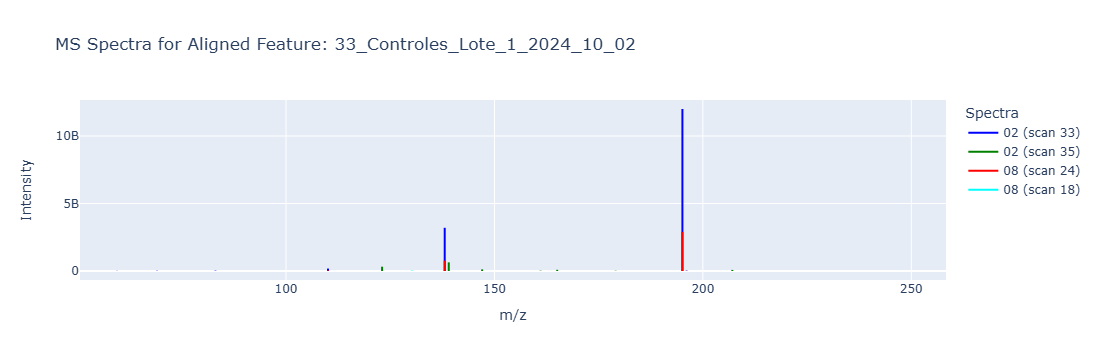

In [22]:
# Function to find the full batch name dynamically from the spectra dictionary
def find_full_batch_name(batch_name, spectra_keys):
    for key in spectra_keys:
        if batch_name in key:
            return key
    return None  # Return None if no match is found

# Function to plot MS spectra for a selected feature using Plotly with vertical lines
def plot_ms_spectra(df, feature_batch, spectra, project_prefix):
    try:
        row = df[df['feature_batch'] == feature_batch].iloc[0]
        aligned_features = row['aligned_features'].split('; ')
        
        fig = go.Figure()

        # Define a list of colors to cycle through
        colors = cycle(['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black'])

        # Get the keys of the spectra dictionary
        spectra_keys = spectra.keys()

        for batch in aligned_features:
            scan_with_prefix, batch_name = batch.rsplit('_', 1)
            scan = scan_with_prefix.split('_')[0]
            
            # Dynamically find the full batch name from spectra_keys
            full_batch_name = find_full_batch_name(batch_name, spectra_keys)

            if full_batch_name is None:
                print(f"Batch name {batch_name} not found in spectra.")  # Debug statement
                continue

            print(f"Processing: scan={scan}, batch_name={batch_name}, full_batch_name={full_batch_name}")  # Debug statement

            spectrum = next((s for s in spectra[full_batch_name] if s['params'].get('FEATURE_ID') == scan), None)

            if spectrum:
                mz_values = spectrum['m/z array']
                intensity_values = spectrum['intensity array']
                label = f'{batch_name} (scan {scan})'.replace('_', ' ')
                color = next(colors)
                # Add vertical lines without markers
                for mz, intensity in zip(mz_values, intensity_values):
                    fig.add_trace(go.Scatter(x=[mz, mz], y=[0, intensity], mode='lines', line=dict(color=color), name=label, showlegend=False))
                # Add a single entry to the legend
                fig.add_trace(go.Scatter(x=[None], y=[None], mode='lines', line=dict(color=color), name=label))
                print(f"Plotted: {label}")  # Debug statement
            else:
                print(f"Spectrum not found for scan: {scan}, batch: {full_batch_name}")  # Debug statement

        fig.update_layout(title=f'MS Spectra for Aligned Feature: {feature_batch}',
                          xaxis_title='m/z',
                          yaxis_title='Intensity',
                          legend_title='Spectra')
        fig.show()
    except IndexError:
        print(f"No data found for feature batch: {feature_batch}")

# Example usage:
feature_batch = '33_Controles_Lote_1_2024_10_02'
plot_ms_spectra(MSfiltered_aligned_features_df, feature_batch, spectra, "Controles_Lote_")


Processing: scan=24, batch_name=02, full_batch_name=Controles_Lote_1_2024_10_02
Plotted: 02 (scan 24)
Processing: scan=17, batch_name=08, full_batch_name=Controles_Lote_3_2024_10_08
Spectrum not found for scan: 17, batch: Controles_Lote_3_2024_10_08


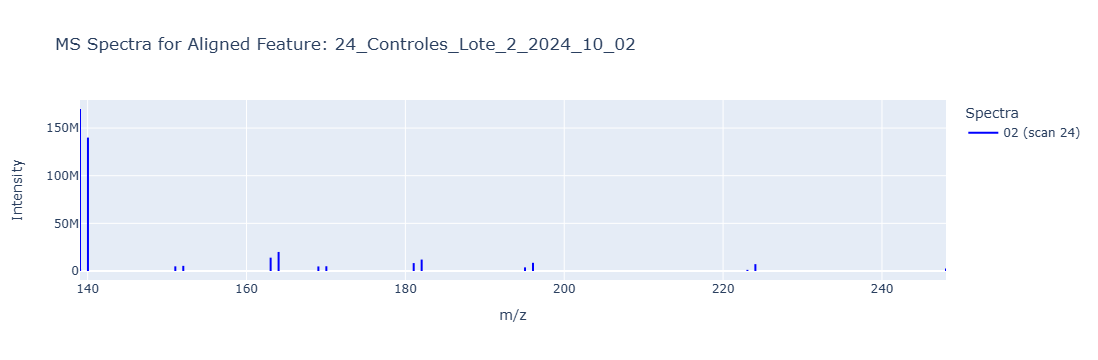

In [30]:
# Function to plot random MS spectra using Plotly with vertical lines
def plot_random_ms_spectra(df, spectra, project_prefix):
    random_row = df.sample(n=1).iloc[0]
    feature_batch = random_row['feature_batch']
    plot_ms_spectra(df, feature_batch, spectra, project_prefix)

# Example usage:
plot_random_ms_spectra(MSfiltered_aligned_features_df, spectra, project_prefix)


---
#### Organize dataset

In [31]:
# Initialize a dictionary to store the combined classification row
classification_row = {'feature_info': 'group'}

# Loop through each file to process them
for file in file_paths:
    df = pd.read_csv(file)
    
    # Get the batch identifier from the filename
    filename = os.path.basename(file).replace('_MetaboAnalyst.csv', '')
    
    # Get the first row
    first_row = df.iloc[0].copy()
    
    # Append the batch identifier to each value in the first row
    for col in first_row.index:
        if col not in ['row ID', 'label']:  # Exclude non-sample columns
            classification_row[f"{filename}_{col}"] = first_row[col]

# Convert the combined row dictionary to a DataFrame with a single row
classification_combined = pd.DataFrame([classification_row])

# Replace NaN values with 0
classification_combined.fillna(0, inplace=True)

# Create the subdirectory if it doesn't exist
output_dir = os.path.join(directory_path, 'combined_results')
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Save the modified DataFrame to the new subdirectory
output_file_path = os.path.join(output_dir, 'classification.csv')
classification_combined.to_csv(output_file_path, index=False)

print(f"Modified combined file saved at: {output_file_path}")

# Display the combined classification DataFrame
display(classification_combined)

Modified combined file saved at: C:\Users\borge\Documents\Batch_correction_from_MZmine\CQ_Batches\combined_results\classification.csv


,feature_info,Controles_Lote_1_2024_10_02_Filename,Controles_Lote_1_2024_10_02_BLANK_20231024145036.mzML,Controles_Lote_1_2024_10_02_BLANK_20231024201047.mzML,Controles_Lote_1_2024_10_02_BLANK_20231025021141.mzML,Controles_Lote_1_2024_10_02_BLANK_20231024224356.mzML,Controles_Lote_1_2024_10_02_BLANK_20231024172649.mzML,Controles_Lote_1_2024_10_02_BLANK.mzML,Controles_Lote_1_2024_10_02_MPCQExt_20231024174844.mzML,Controles_Lote_1_2024_10_02_MPCQExt_20231024230550.mzML,...,Controles_Lote_4_2024_10_08_Filename,Controles_Lote_4_2024_10_08_BLANK_20231028112847.mzML,Controles_Lote_4_2024_10_08_BLANK_20231028024402.mzML,Controles_Lote_4_2024_10_08_BLANK_20231028065531.mzML,Controles_Lote_4_2024_10_08_CQExt_20231028113944.mzML,Controles_Lote_4_2024_10_08_MPCQExt_20231028115041.mzML,Controles_Lote_4_2024_10_08_MPCQExt_20231028030601.mzML,Controles_Lote_4_2024_10_08_CQExt_20231028025504.mzML,Controles_Lote_4_2024_10_08_CQExt_20231028070628.mzML,Controles_Lote_4_2024_10_08_MPCQExt_20231028071725.mzML
0,group,group,Blank,Blank,Blank,Blank,Blank,Blank,MPQCExt,MPQCExt,...,group,Blank,Blank,Blank,QCExt,MPQCExt,MPQCExt,QCExt,QCExt,MPQCExt


In [34]:
# Identify the sample columns to keep
sample_columns = [col for col in MSfiltered_aligned_features_df.columns if col.endswith('.mzML') or col.endswith('.mzXML')]

# Create a new DataFrame with the concatenated 'scan_number', 'mz_value', 'rt_value' column and the sample columns
filtered_df = MSfiltered_aligned_features_df[sample_columns].copy()
filtered_df['feature_info'] = MSfiltered_aligned_features_df.apply(lambda row: f"{int(row['scan_number'])}_{row['mz_value']}_{row['rt_value']}", axis=1)

# Reorder columns to have 'feature_info' first
filtered_df = filtered_df[['feature_info'] + sample_columns]

# Replace all NaN values with zeros
filtered_df.fillna(0, inplace=True)

# Create the subdirectory if it doesn't exist
output_dir = os.path.join(directory_path, 'alignment_info_df')
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Save the new DataFrame to a CSV file
output_file_path = os.path.join(output_dir, 'filtered_aligned_features.csv')
filtered_df.to_csv(output_file_path, index=False)

# Display the filtered DataFrame
pd.set_option("max_colwidth", None)
display(filtered_df)

,feature_info,df_Controles_Lote_1_2024_10_02_BLANK_20231024145036.mzML,df_Controles_Lote_1_2024_10_02_BLANK_20231024201047.mzML,df_Controles_Lote_1_2024_10_02_BLANK_20231025021141.mzML,df_Controles_Lote_1_2024_10_02_BLANK_20231024224356.mzML,df_Controles_Lote_1_2024_10_02_BLANK_20231024172649.mzML,df_Controles_Lote_1_2024_10_02_BLANK.mzML,df_Controles_Lote_1_2024_10_02_MPCQExt_20231024174844.mzML,df_Controles_Lote_1_2024_10_02_MPCQExt_20231024230550.mzML,df_Controles_Lote_1_2024_10_02_MPCQExt_20231025023336.mzML,...,df_Controles_Lote_3_2024_10_08_MPCQExt_20231027214406.mzML,df_Controles_Lote_4_2024_10_08_BLANK_20231028112847.mzML,df_Controles_Lote_4_2024_10_08_BLANK_20231028024402.mzML,df_Controles_Lote_4_2024_10_08_BLANK_20231028065531.mzML,df_Controles_Lote_4_2024_10_08_CQExt_20231028113944.mzML,df_Controles_Lote_4_2024_10_08_MPCQExt_20231028115041.mzML,df_Controles_Lote_4_2024_10_08_MPCQExt_20231028030601.mzML,df_Controles_Lote_4_2024_10_08_CQExt_20231028025504.mzML,df_Controles_Lote_4_2024_10_08_CQExt_20231028070628.mzML,df_Controles_Lote_4_2024_10_08_MPCQExt_20231028071725.mzML
1,3_351.0694_0.22,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,...,0,0.0,0.0,0.0,0,0,0,0,0,0
2,4_104.1071_0.23,0.0,0.0,0.0,0.0,0.0,0.0,7279942.5,1.0058472E7,8505989.0,...,0,0.0,0.0,0.0,0,0,0,0,0,0
3,5_381.081_0.23,0.0,0.0,0.0,0.0,0.0,0.0,5838549.0,8136458.5,5668001.0,...,7831365.0,0.0,0.0,0.0,7778376.5,4645570.5,8628371.0,8332121.5,3722592.75,4377923.5
4,6_118.0865_0.24,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,...,0,0.0,0.0,0.0,5706740.0,0,6486468.5,0,0,0
5,7_213.0644_0.24,0.0,0.0,0.0,0.0,0.0,0.0,0,0,6863877.5,...,7215755.0,0.0,0.0,0.0,4117255.0,4751216.0,5383973.0,0,0,0
6,9_360.1512_0.28,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,...,0,0.0,0.0,0.0,0,0,0,0,0,0
7,10_175.1084_0.29,0.0,0.0,0.0,0.0,0.0,0.0,7.1225456E7,1.10672208E8,7.7475304E7,...,1.49952992E8,0.0,0.0,0.0,1.20186312E8,9.626736E7,0,1.29326984E8,7.31016E7,9.7179192E7
8,11_158.0816_0.29,0.0,0.0,0.0,0.0,0.0,0.0,7465561.5,1.1231103E7,7659732.0,...,1.5319899E7,0.0,0.0,0.0,1.3111087E7,9545828.0,1.5516005E7,1.4992811E7,0,9754059.0
9,12_176.1118_0.29,0.0,0.0,0.0,0.0,0.0,0.0,0,8573376.0,0,...,1.1721333E7,0.0,0.0,0.0,9206045.0,0,0,1.0204074E7,0,0
10,13_337.1604_0.31,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,...,9022089.0,0.0,0.0,0.0,0,0,8053241.0,0,0,0


In [35]:
# Identify the sample columns to keep
sample_columns = [col for col in MSfiltered_aligned_features_df.columns if col.endswith('.mzML') or col.endswith('.mzXML')]

# Create a new DataFrame with the concatenated 'scan_number', 'mz_value', 'rt_value' column and the sample columns
filtered_df = MSfiltered_aligned_features_df[sample_columns].copy()
filtered_df['feature_info'] = MSfiltered_aligned_features_df.apply(lambda row: f"{int(row['scan_number'])}_{row['mz_value']}_{row['rt_value']}", axis=1)

# Reorder columns to have 'feature_info' first
filtered_df = filtered_df[['feature_info'] + sample_columns]

# Replace all NaN values with zeros
filtered_df.fillna(0, inplace=True)

# Initialize a dictionary to store the combined classification row
classification_row = {'feature_info': 'group'}

# Loop through each file to process them
for file in file_paths:
    df = pd.read_csv(file)
    
    # Get the batch identifier from the filename
    filename = os.path.basename(file).replace('_MetaboAnalyst.csv', '')
    
    # Get the first row
    first_row = df.iloc[0].copy()
    
    # Append the batch identifier to each value in the first row
    for col in first_row.index:
        if col not in ['row ID', 'label']:  # Exclude non-sample columns
            classification_row[f"{filename}_{col}"] = first_row[col]

# Create a classification row based on the sample columns of filtered_df
classification_data = {'feature_info': 'group'}
for col in sample_columns:
    for key in classification_row.keys():
        if key in col:
            classification_data[col] = classification_row[key]

# Convert the combined classification dictionary to a DataFrame with a single row
classification_df = pd.DataFrame([classification_data])

# Replace NaN values with zeros
classification_df.fillna(0, inplace=True)

# Combine classification_df as the first row of filtered_df
final_df = pd.concat([classification_df, filtered_df], ignore_index=True)

# Create the subdirectory if it doesn't exist
output_dir = os.path.join(directory_path, 'combined_results')
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Save the modified DataFrame to the new subdirectory
output_file_path = os.path.join(output_dir, 'filtered_aligned_features_with_classification.csv')
final_df.to_csv(output_file_path, index=False)

print(f"Modified combined file saved at: {output_file_path}")

# Display the final DataFrame
pd.set_option("max_colwidth", None)
display(final_df)

Modified combined file saved at: C:\Users\borge\Documents\Batch_correction_from_MZmine\CQ_Batches\combined_results\filtered_aligned_features_with_classification.csv


,feature_info,df_Controles_Lote_1_2024_10_02_BLANK_20231024145036.mzML,df_Controles_Lote_1_2024_10_02_BLANK_20231024201047.mzML,df_Controles_Lote_1_2024_10_02_BLANK_20231025021141.mzML,df_Controles_Lote_1_2024_10_02_BLANK_20231024224356.mzML,df_Controles_Lote_1_2024_10_02_BLANK_20231024172649.mzML,df_Controles_Lote_1_2024_10_02_BLANK.mzML,df_Controles_Lote_1_2024_10_02_MPCQExt_20231024174844.mzML,df_Controles_Lote_1_2024_10_02_MPCQExt_20231024230550.mzML,df_Controles_Lote_1_2024_10_02_MPCQExt_20231025023336.mzML,...,df_Controles_Lote_3_2024_10_08_MPCQExt_20231027214406.mzML,df_Controles_Lote_4_2024_10_08_BLANK_20231028112847.mzML,df_Controles_Lote_4_2024_10_08_BLANK_20231028024402.mzML,df_Controles_Lote_4_2024_10_08_BLANK_20231028065531.mzML,df_Controles_Lote_4_2024_10_08_CQExt_20231028113944.mzML,df_Controles_Lote_4_2024_10_08_MPCQExt_20231028115041.mzML,df_Controles_Lote_4_2024_10_08_MPCQExt_20231028030601.mzML,df_Controles_Lote_4_2024_10_08_CQExt_20231028025504.mzML,df_Controles_Lote_4_2024_10_08_CQExt_20231028070628.mzML,df_Controles_Lote_4_2024_10_08_MPCQExt_20231028071725.mzML
0,group,Blank,Blank,Blank,Blank,Blank,Blank,MPQCExt,MPQCExt,MPQCExt,...,MPQCExt,Blank,Blank,Blank,QCExt,MPQCExt,MPQCExt,QCExt,QCExt,MPQCExt
1,3_351.0694_0.22,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,...,0,0.0,0.0,0.0,0,0,0,0,0,0
2,4_104.1071_0.23,0.0,0.0,0.0,0.0,0.0,0.0,7279942.5,1.0058472E7,8505989.0,...,0,0.0,0.0,0.0,0,0,0,0,0,0
3,5_381.081_0.23,0.0,0.0,0.0,0.0,0.0,0.0,5838549.0,8136458.5,5668001.0,...,7831365.0,0.0,0.0,0.0,7778376.5,4645570.5,8628371.0,8332121.5,3722592.75,4377923.5
4,6_118.0865_0.24,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,...,0,0.0,0.0,0.0,5706740.0,0,6486468.5,0,0,0
5,7_213.0644_0.24,0.0,0.0,0.0,0.0,0.0,0.0,0,0,6863877.5,...,7215755.0,0.0,0.0,0.0,4117255.0,4751216.0,5383973.0,0,0,0
6,9_360.1512_0.28,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,...,0,0.0,0.0,0.0,0,0,0,0,0,0
7,10_175.1084_0.29,0.0,0.0,0.0,0.0,0.0,0.0,7.1225456E7,1.10672208E8,7.7475304E7,...,1.49952992E8,0.0,0.0,0.0,1.20186312E8,9.626736E7,0,1.29326984E8,7.31016E7,9.7179192E7
8,11_158.0816_0.29,0.0,0.0,0.0,0.0,0.0,0.0,7465561.5,1.1231103E7,7659732.0,...,1.5319899E7,0.0,0.0,0.0,1.3111087E7,9545828.0,1.5516005E7,1.4992811E7,0,9754059.0
9,12_176.1118_0.29,0.0,0.0,0.0,0.0,0.0,0.0,0,8573376.0,0,...,1.1721333E7,0.0,0.0,0.0,9206045.0,0,0,1.0204074E7,0,0
